# Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
def print_row(item, decimals=2):
    if type(item) == str:
        print(f'& {item} ', end='')    
    else: print(f'& {np.round(item, decimals):03} ', end='')

In [3]:
dataset_full_form = {
    'electricity': 'Electricity',
    'traffic': 'Traffic',
    'mimic_iii': 'MIMIC-III'
}

In [4]:
def reduce_df(df:pd.DataFrame):
    # df[df['area']==0.05]
    return df.groupby('metric')[['comp', 'suff']].aggregate('mean').reset_index()

int_metric_map = {
    'electricity': ['mae'],
    'traffic': ['mae'],
    'mimic_iii': ['auc']
}

test_metric_map = {
    'electricity': ['mae', 'mse'],
    'traffic': ['mae', 'mse'],
    'mimic_iii': ['auc', 'accuracy']
}

datasets = ['electricity', 'traffic', 'mimic_iii']
models = ['DLinear', 'MICN', 'SegRNN', 'iTransformer']
attr_methods = [
    'feature_ablation', 'augmented_occlusion', 
    'feature_permutation', 
    'integrated_gradients', 'gradient_shap','dyna_mask',
    'winIT', 'tsr', 'wtsr'
]

short_form = {
    'feature_ablation': 'FA',
    'occlusion':'FO',
    'augmented_occlusion': 'AFO',
    'feature_permutation': 'FP',
    'winIT': 'WinIT',
    'tsr':'TSR',
    'tsr2':'TSR',
    'wtsr': 'WinTSR',
    'gradient_shap': 'GS',
    'integrated_gradients': 'IG',
    'dyna_mask': 'DM'
}
NUM_ITERATIONS = 3

# Summarize

## Take average

In [5]:
import os

results = []
for dataset in datasets:
    for attr_method in attr_methods:
        for metric in int_metric_map[dataset]:
            for model in models:
                for itr_no in range(1, NUM_ITERATIONS+1):
                    attr_file = f'results/{dataset}_{model}/{itr_no}/{attr_method}.csv'
                    df = pd.read_csv(attr_file)
                    # if os.path.exists(attr_file):
                    #     df = pd.read_csv(attr_file)
                    # else:
                    #     batch_file = f'results/{dataset}_{model}/{itr_no}/batch_{attr_method}.csv'
                    #     if os.path.exists(batch_file):
                    #         df = pd.read_csv(batch_file)
                    #         df = df.groupby(['metric', 'area'])[
                    #             ['comp', 'suff']
                    #         ].aggregate('mean').reset_index()
                    #     else:
                    #         print(f'File not found: {attr_file}')
                    #         continue
                        
                    df = reduce_df(df)
                    comp, suff= df[df['metric']==metric][['comp', 'suff']].values[0]
                    
                    results.append([
                        dataset, attr_method, metric, model, itr_no, comp, suff
                    ])
                    

result_df = pd.DataFrame(results, columns=['dataset', 'attr_method', 'metric', 'model', 'itr_no', 'comp', 'suff'])
result_df.head(3)

,dataset,attr_method,metric,model,itr_no,comp,suff
0,electricity,feature_ablation,mae,DLinear,1,10.860281,12.558014
1,electricity,feature_ablation,mae,DLinear,2,10.433965,12.210792
2,electricity,feature_ablation,mae,DLinear,3,10.852369,12.406156


In [6]:
# import os
# import sys

# walk_dir = 'results'

# print('walk_dir = ' + walk_dir)
# print('walk_dir (absolute) = ' + os.path.abspath(walk_dir))

# for root, subdirs, files in os.walk(walk_dir):
#     # print('--\nroot = ' + root)
#     # print('list_file_path = ' + list_file_path)

#     for filename in files:
#         file_path = os.path.join(root, filename)
#         if 'tsr2.csv' in filename: 
#             pass
#             # print(f'file {filename} (full path: {file_path})')
#             # os.remove(file_path)

In [7]:
result_df = result_df.groupby(['dataset', 'attr_method', 'metric', 'model'])[['comp', 'suff']].mean().reset_index()
result_df = result_df[result_df['metric'].isin(['mae', 'auc'])]

selected = result_df['metric'].isin(['auc', 'accuracy'])
result_df.loc[selected, ['comp', 'suff']] = 1 - result_df[selected][['comp', 'suff']]

## Ranking

In [8]:
result_df['comp_rank'] = result_df.groupby(['dataset', 'metric', 'model'])['comp'].rank(ascending=False)
result_df['suff_rank'] = result_df.groupby(['dataset', 'metric', 'model'])['suff'].rank(ascending=True)
result_df.groupby(['dataset', 'metric', 'attr_method'])[['comp_rank', 'suff_rank']].mean().reset_index()

,dataset,metric,attr_method,comp_rank,suff_rank
0,electricity,mae,augmented_occlusion,5.25,4.00
1,electricity,mae,dyna_mask,9.00,7.75
2,electricity,mae,feature_ablation,3.75,3.00
3,electricity,mae,feature_permutation,8.00,6.50
4,electricity,mae,gradient_shap,6.75,7.50
5,electricity,mae,integrated_gradients,2.25,8.25
6,electricity,mae,tsr,2.25,1.75
7,electricity,mae,winIT,6.00,5.00
8,electricity,mae,wtsr,1.75,1.25
9,mimic_iii,auc,augmented_occlusion,5.50,2.50


In [9]:
df = pd.concat([
    result_df.drop(columns='suff_rank').rename(columns={'comp_rank': 'rank'}), 
    result_df.drop(columns='comp_rank').rename(columns={'suff_rank': 'rank'})
], axis=0)

ranks = df.groupby(['dataset', 'metric', 'attr_method'])['rank'].mean().round(1).reset_index(name='mean_rank')
ranks['rank'] = ranks.groupby(['dataset', 'metric'])['mean_rank'].rank()
ranks

,dataset,metric,attr_method,mean_rank,rank
0,electricity,mae,augmented_occlusion,4.6,4.0
1,electricity,mae,dyna_mask,8.4,9.0
2,electricity,mae,feature_ablation,3.4,3.0
3,electricity,mae,feature_permutation,7.2,8.0
4,electricity,mae,gradient_shap,7.1,7.0
5,electricity,mae,integrated_gradients,5.2,5.0
6,electricity,mae,tsr,2.0,2.0
7,electricity,mae,winIT,5.5,6.0
8,electricity,mae,wtsr,1.5,1.0
9,mimic_iii,auc,augmented_occlusion,4.0,4.0


## Pyplot table

### Utils

In [10]:
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from matplotlib import cm
import matplotlib.pyplot as plt
from utils.plot_config import *

%matplotlib inline

In [11]:
def get_merged(dataset):
    df = result_df[result_df['dataset']==dataset]
    comp = df.pivot(
        index='attr_method', columns='model', values='comp'
    ).reset_index()
    comp['attr_method'] = comp['attr_method'].apply(lambda x: short_form[x])
    comp.set_index('attr_method', inplace=True)
    
    suff = df.pivot(
        index='attr_method', columns='model', values='suff'
    ).reset_index()
    suff['attr_method'] = suff['attr_method'].apply(lambda x: short_form[x])
    suff.set_index('attr_method', inplace=True)
    
    ranks_ = ranks[ranks['dataset']=='electricity'].copy()
    ranks_['attr_method'] = ranks_['attr_method'].apply(lambda x: short_form[x])
    ranks_.drop(columns=['dataset', 'metric'], inplace=True)
    ranks_.set_index('attr_method', inplace=True)
    
    merged = pd.merge(comp, suff, on='attr_method', how='inner')
    merged = pd.merge(merged, ranks_, on='attr_method', how='inner')
    merged = merged.loc[[short_form[attr] for attr in attr_methods]]
    
    return merged

In [12]:
def get_definitions(merged):
    if merged.max()[0] < 1:
        formatter=lambda x: round(x, 2)
    else:
        formatter=lambda x: round(x, 1)
    
    textprops = {
        "ha": "center",
        "bbox": {"boxstyle": "ellipse", "pad": 0.1},
    }
    
    col_defs = (
        [
            ColumnDefinition(name='attr_method', title='Method')
        ] + [
            ColumnDefinition(
                name=f'{model}_x', title=model, 
                cmap=normed_cmap(merged[f'{model}_x'], cmap=cm.BuGn),
                group='Comprehensiveness',
                textprops=textprops, formatter=formatter,
                width=1.2 if model == 'iTransformer' else 1,
                border="left" if i == 0 else None
            )
            for i, model in enumerate(models)
        ]+ [
            ColumnDefinition(
                name=f'{model}_y', title=model, 
                cmap=normed_cmap(merged[f'{model}_y'], cmap=cm.BuGn_r),
                group='Sufficiency',
                textprops=textprops, formatter=formatter,
                width=1.2 if model == 'iTransformer' else 1,
                border="left" if i == 0 else None
            )
            for i, model in enumerate(models)
        ] + [
            ColumnDefinition(
                name='mean_rank', title='Avg', group='Rank',
                textprops={"ha": "center"}, formatter=lambda x: round(x, 1),
                cmap=normed_cmap(merged['mean_rank'], cmap=cm.BuGn_r),
                border="left"
            ),
            ColumnDefinition(
                name='rank', title='Overall', group='Rank',
                formatter=lambda x: int(x),
                textprops={
                    "ha": "center", 
                    # "bbox": {"boxstyle": "ellipse", "pad": 0.1},
                },
                cmap=normed_cmap(merged['rank'], cmap=cm.BuGn_r),
                
            )
        ]
    )
    
    return col_defs

### Plot

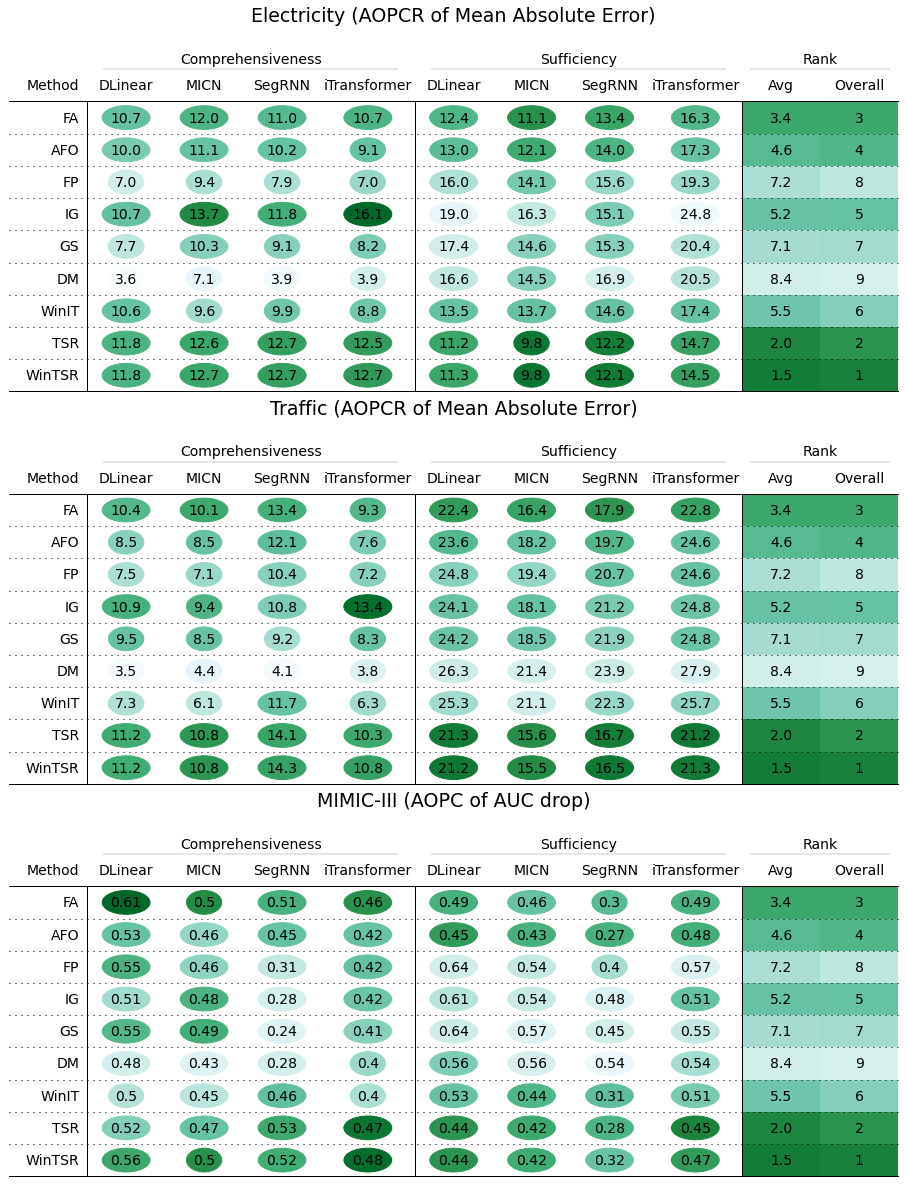

In [13]:
fig, axes = plt.subplots(len(datasets), 1, figsize=(16, 21))

for i in range(len(datasets)):
    ax = axes[i]
    dataset = datasets[i]
    
    merged = get_merged(dataset)
    col_defs = get_definitions(merged)

    table = Table(
        merged,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        textprops={"fontsize": 14},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
    )
    
    if dataset== 'mimic_iii':
        ax.set_title(f'{dataset_full_form[dataset]} (AOPC of AUC drop)', fontsize=19)
    else:
        ax.set_title(f'{dataset_full_form[dataset]} (AOPCR of Mean Absolute Error)', fontsize=19)
    
plt.subplots_adjust(hspace=0.1)

# Time efficiency

In [14]:
time_efficiency = pd.read_csv('results/time_efficiency.csv')
time_efficiency = time_efficiency[time_efficiency['name']!='occlusion']
time_efficiency.head(3)

,dataset,model,iteration,name,timestamp,duration,settings
0,traffic,DLinear,1,feature_ablation,2024-07-26 00:28:04.747253,0:01:13.289547,NaN
1,electricity,DLinear,1,feature_ablation,2024-07-26 00:28:09.959615,0:01:49.416156,NaN
2,mimic_iii,DLinear,1,feature_ablation,2024-07-26 00:29:14.800882,0:01:51.229460,NaN


In [15]:
time_efficiency['minutes'] = pd.to_timedelta(time_efficiency['duration']).dt.seconds / 60
df = time_efficiency.groupby(['dataset', 'model', 'name'])['minutes'].mean().reset_index()
df

,dataset,model,name,minutes
0,electricity,DLinear,augmented_occlusion,1.972222
1,electricity,DLinear,dyna_mask,1.438889
2,electricity,DLinear,feature_ablation,1.827778
3,electricity,DLinear,feature_permutation,1.911111
4,electricity,DLinear,gradient_shap,1.483333
...,...,...,...,...
112,traffic,iTransformer,integrated_gradients,3.155556
113,traffic,iTransformer,tsr,53.366667
114,traffic,iTransformer,tsr2,21.755556
115,traffic,iTransformer,winIT,4.150000


## Write latex table

In [16]:
print("Dataset & Model & " + " & ".join([short_form[attr_method] for attr_method in attr_methods]) + " \\\\ \\hline")
for dataset in datasets:
    print("\multirow{4}{*}{" + f'{dataset_full_form[dataset]}' + "}", end='')
    for model in models:
        print(f' & {model}', end='')
        for attr_method in attr_methods:    
            value = df[(df['dataset']==dataset) & (df['model']==model) & (df['name']==attr_method)]['minutes'].values[0]
            print_row(value, decimals=1)
        print('\\\\ ')
    print('\\hline')

Dataset & Model & FA & AFO & FP & IG & GS & DM & WinIT & TSR & WinTSR \\ \hline
\multirow{4}{*}{Electricity} & DLinear& 1.8 & 2.0 & 1.9 & 2.3 & 1.5 & 1.4 & 2.8 & 25.9 & 1.9 \\ 
 & MICN& 6.4 & 6.6 & 6.5 & 7.1 & 4.6 & 4.5 & 7.4 & 50.1 & 5.7 \\ 
 & SegRNN& 2.6 & 2.8 & 2.7 & 2.8 & 2.0 & 2.0 & 3.6 & 30.8 & 2.6 \\ 
 & iTransformer& 5.2 & 5.4 & 5.3 & 4.6 & 3.7 & 3.6 & 6.2 & 77.8 & 6.3 \\ 
\hline
\multirow{4}{*}{Traffic} & DLinear& 1.2 & 1.3 & 1.3 & 1.6 & 1.0 & 0.9 & 1.8 & 17.3 & 1.2 \\ 
 & MICN& 4.4 & 4.5 & 4.4 & 4.6 & 3.1 & 3.0 & 5.0 & 34.0 & 3.8 \\ 
 & SegRNN& 1.8 & 1.8 & 1.8 & 1.9 & 1.3 & 1.3 & 2.3 & 20.5 & 1.7 \\ 
 & iTransformer& 3.5 & 3.6 & 3.6 & 3.2 & 2.5 & 2.5 & 4.2 & 53.4 & 4.3 \\ 
\hline
\multirow{4}{*}{MIMIC-III} & DLinear& 1.9 & 2.2 & 2.1 & 0.4 & 0.3 & 0.5 & 6.8 & 8.0 & 4.4 \\ 
 & MICN& 6.9 & 7.3 & 7.1 & 0.8 & 0.6 & 0.8 & 12.0 & 13.4 & 7.4 \\ 
 & SegRNN& 3.8 & 4.7 & 4.7 & 0.8 & 0.5 & 0.6 & 7.9 & 10.7 & 5.9 \\ 
 & iTransformer& 5.2 & 5.6 & 5.4 & 0.6 & 0.5 & 0.7 & 10.2 & 11.5 & 6.4 

## Overall rank

In [17]:
df.loc[:, 'rank'] = df.groupby(['dataset', 'model'])['minutes'].rank()
time_ranks = df.groupby('name')['rank'].mean().reset_index()
time_ranks['Overall'] = time_ranks['rank'].rank()
time_ranks

,name,rank,Overall
0,augmented_occlusion,6.000000,7.0
1,dyna_mask,1.500000,1.0
2,feature_ablation,3.833333,3.0
3,feature_permutation,5.000000,5.0
4,gradient_shap,1.666667,2.0
5,integrated_gradients,4.833333,4.0
6,tsr,9.166667,9.0
7,tsr2,9.777778,10.0
8,winIT,7.833333,8.0
9,wtsr,5.333333,6.0


## Boxplot

In [18]:
# from utils.plot_config import *

# rows, columns = 3, 4
# fig, axes = plt.subplots(rows, columns, figsize=(32, 10), sharex=True, sharey=True)

# for row in range(rows):
#     for col in range(columns):
#         ax = axes[row][col]
#         dataset = datasets[row]
#         model = models[col]
#         df = time_efficiency[(time_efficiency['dataset']==dataset) & (time_efficiency['model']==model)]
#         # df['name'] = df['name'].apply(lambda x: short_form[x])
        
#         df = df.groupby('name')['minutes'].mean().reset_index()
#         df['minutes']  = df['minutes'].apply(np.log10)
#         df.plot(x='name', y='minutes', ax=ax, kind='bar', legend=False, rot=90)
#         ax.set_xlabel('')
#         if row == 0:
#             ax.set_title(model)
#         if col == 0:
#             ax.set_ylabel(dataset_full_form[dataset])
            
# fig.supylabel('Log Time (minute)', fontsize=36, x=0.073, y=0.5)
# plt.show()

In [19]:
df = time_efficiency.groupby(['dataset', 'model', 'name'])['minutes'].mean().reset_index()
df = df[df['name']!='tsr2']

(0.0, 3.852440833672604)
(0.0, 3.680692393962445)
(0.0, 3.051085674386262)


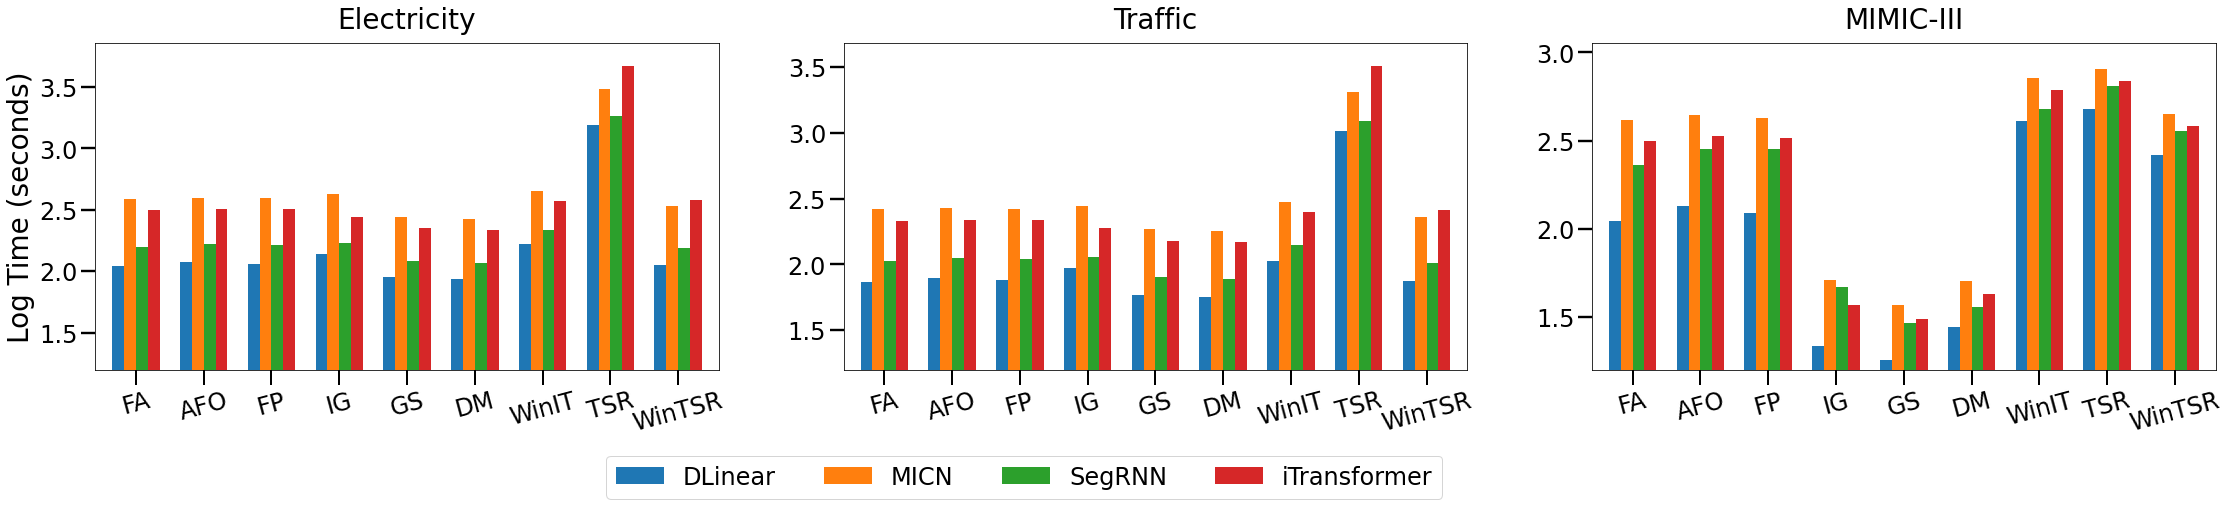

In [20]:
fig, axes = plt.subplots(1, len(datasets), figsize=(38, 6),)
for i, dataset in enumerate(datasets):
    temp = df[df['dataset']==dataset].copy()
    temp['name'] = temp['name'].apply(lambda x: short_form[x])
    temp['minutes'] *= 60
    temp['minutes'] = temp['minutes'].apply(np.log10)
    temp = temp.pivot(index='name', columns='model', values='minutes')
    
    # order the names
    temp = temp.loc[[short_form[name] for name in attr_methods]]
    
    if i == 0:
        temp.plot.bar(rot=15, legend=False, ylabel='Log Time (seconds)', xlabel='', ax=axes[i], width=0.7)
    else: 
        temp.plot.bar(rot=15, legend=False, ylabel='', xlabel='', ax=axes[i], width=0.7)
    axes[i].set_title(dataset_full_form[dataset])
    
    print(axes[i].get_ylim())
    axes[i].set_ylim(1.2)
    # axes[i].grid()
    if i == len(axes) // 2:
        axes[i].legend(loc='center left', bbox_to_anchor=(-.4, -0.33), ncol=4)

# plt.savefig(f'results/time efficiency.jpg', dpi=100, bbox_inches="tight")

# Variable Lookback

In [21]:
lookbacks = {
    'electricity':[24, 48], 
    'traffic': [24, 48], 
    'mimic_iii': [24, 36]
}
model = 'iTransformer'
results = []
for dataset in datasets:
    for attr_method in attr_methods[-3:]:
        for metric in int_metric_map[dataset]:
            for lookback in lookbacks[dataset]:
                for itr_no in range(1, NUM_ITERATIONS+1):
                    df = pd.read_csv(f'results/{dataset}_{model}_sl_{lookback}/{itr_no}/{attr_method}.csv')
                    df = reduce_df(df)
                    comp, suff= df[df['metric']==metric][['comp', 'suff']].values[0]
                    
                    results.append([
                        dataset, attr_method, metric, lookback, itr_no, comp, suff
                    ])

result_df = pd.DataFrame(results, columns=['dataset', 'attr_method', 'metric', 'lookback', 'itr_no', 'comp', 'suff'])

In [22]:
result_df = result_df.groupby(['dataset', 'attr_method', 'metric', 'lookback'])[['comp', 'suff']].mean().reset_index()
result_df

,dataset,attr_method,metric,lookback,comp,suff
0,electricity,tsr,mae,24,17.238143,21.062192
1,electricity,tsr,mae,48,14.255044,15.608042
2,electricity,winIT,mae,24,14.380609,22.973425
3,electricity,winIT,mae,48,11.472749,17.859977
4,electricity,wtsr,mae,24,17.876141,20.678208
5,electricity,wtsr,mae,48,14.851056,15.264080
6,mimic_iii,tsr,auc,24,0.418306,0.389257
7,mimic_iii,tsr,auc,36,0.500166,0.521904
8,mimic_iii,winIT,auc,24,0.450934,0.370624
9,mimic_iii,winIT,auc,36,0.548548,0.447009


In [23]:
for dataset in datasets:
    print("\multirow{3}{*}{" + f' {dataset}' + "}", end='')
    for attr_method in attr_methods[-3:]:
        print(f' & {short_form[attr_method]}', end='')
        for metric in int_metric_map[dataset]:
            for lookback in lookbacks[dataset]:
                values = result_df[
                    (result_df['dataset']==dataset) & (result_df['attr_method']==attr_method) & (result_df['metric']==metric) & (result_df['lookback']==lookback)
                ][['comp', 'suff']].values[0]
                
                if metric in ['auc', 'accuracy']:
                    values = 1 - values
                print(f' & {values[0]:.2f} & {values[1]:.2f}', end='')
            break
        print('\\\\')
    print('\\hline')

\multirow{3}{*}{ electricity} & WinIT & 14.38 & 22.97 & 11.47 & 17.86\\
 & TSR & 17.24 & 21.06 & 14.26 & 15.61\\
 & WinTSR & 17.88 & 20.68 & 14.85 & 15.26\\
\hline
\multirow{3}{*}{ traffic} & WinIT & 9.10 & 25.46 & 7.50 & 26.12\\
 & TSR & 11.61 & 23.04 & 11.01 & 22.40\\
 & WinTSR & 11.39 & 23.27 & 11.32 & 22.71\\
\hline
\multirow{3}{*}{ mimic_iii} & WinIT & 0.55 & 0.63 & 0.45 & 0.55\\
 & TSR & 0.58 & 0.61 & 0.50 & 0.48\\
 & WinTSR & 0.59 & 0.63 & 0.49 & 0.49\\
\hline


In [24]:
result_df.round(2).to_csv('results/var_seq_length.csv', index=False)